In [1]:
!pip install cleantext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# import important modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from string import punctuation 

# sklearn modules
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    plot_confusion_matrix,
    f1_score,
    roc_auc_score,
)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

# text preprocessing modules
from nltk.tokenize import word_tokenize
from cleantext import clean

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import re #regular expression


from wordcloud import WordCloud, STOPWORDS

# Download dependency
for dependency in (
    "brown",
    "names",
    "wordnet",
    "averaged_perceptron_tagger",
    "universal_tagset",
    "stopwords"
):
    nltk.download(dependency)

#nltk.download('stopwords')

import warnings
warnings.filterwarnings("ignore")
# seeding
np.random.seed(123)

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#load data
data = pd.read_csv("spam.tsv", sep="\t")

In [4]:
# show top five rows
data.head()

,label,message,length,punct
0,ham,"Go until jurong point, crazy.. Available only ...",111,9
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,6
3,ham,U dun say so early hor... U c already then say...,49,6
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,2


In [5]:
# check the shape
data.shape

(5572, 4)

In [6]:
# check missing values
data.isnull().sum()

label      0
message    0
length     0
punct      0
dtype: int64

In [7]:
# evalute class distribution
data["label"].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

**In this dataset we have more legitimate messages (ham) than spam messages.**

In [8]:
# collect words from the dataset
def collect_words(data, label):
    collected_words = " "

    # iterate through the csv file
    for val in data.message[data["label"] == label]:

        # typecaste each val to string
        val = str(val)

        # split the value
        tokens = val.split()

        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()

        for words in tokens:
            collected_words = collected_words + words + " "

    return collected_words

Total words 349132


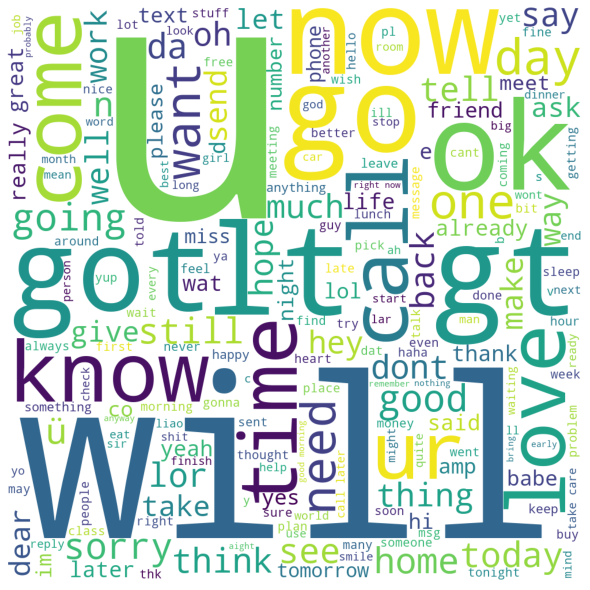

In [9]:
# visualize ham labeled sms
cloud_stopwords = set(STOPWORDS)
ham_words = collect_words(data, label="ham")

print("Total words {}".format(len(ham_words)))

wordcloud = WordCloud(
    width=1000,
    height=1000,
    background_color="white",
    stopwords=cloud_stopwords,
    min_font_size=10,
).generate(ham_words)

# plot the WordCloud image
plt.figure(figsize=(15, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

Total words 104304


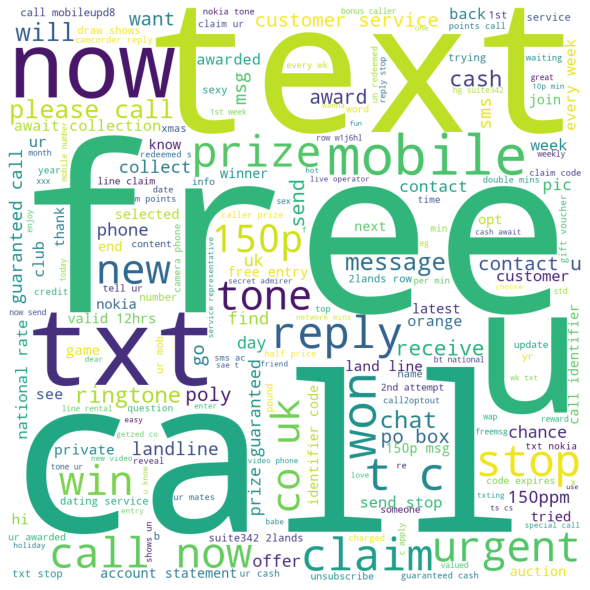

In [10]:
# visualize spam labeled sms
cloud_stopwords = set(STOPWORDS)
spam_words = collect_words(data, label="spam")

print("Total words {}".format(len(spam_words)))

wordcloud = WordCloud(
    width=1000,
    height=1000,
    background_color="white",
    stopwords=cloud_stopwords,
    min_font_size=10,
).generate(spam_words)

# plot the WordCloud image
plt.figure(figsize=(10, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

**In the above figure it shows that the most frequent words are those like call, claim, free, txt, mobile, reply, offer and so on.**

In [11]:
# replace ham to 0 and spam to 1
new_data = data.replace({"ham": 0, "spam": 1})
new_data.head()

,label,message,length,punct
0,0,"Go until jurong point, crazy.. Available only ...",111,9
1,0,Ok lar... Joking wif u oni...,29,6
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,6
3,0,U dun say so early hor... U c already then say...,49,6
4,0,"Nah I don't think he goes to usf, he lives aro...",61,2


In [12]:
stop_words =  stopwords.words('english')

def text_cleaning(text, remove_stop_words=True, lemmatize_words=True):
    # Clean the text, with the option to remove stop_words and to lemmatize word

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9]", " ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"I'm", "I am", text)
    text = re.sub(r"ur", " your ", text)
    text = re.sub(r" nd "," and ",text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r" tkts "," tickets ",text)
    text = re.sub(r" c "," can ",text)
    text = re.sub(r" e g ", " eg ", text)
    text =  re.sub(r'http\S+',' link ', text)
    text = re.sub(r'\b\d+(?:\.\d+)?\s+', '', text) # remove numbers
    text = re.sub(r" u "," you ",text)
    text = text.lower()  # set in lowercase 
        
    # Remove punctuation from text
    text = ''.join([c for c in text if c not in punctuation])
    
    # Optionally, remove stop words
    if remove_stop_words:
        text = text.split()
        text = [w for w in text if not w in stop_words]
        text = " ".join(text)
    
    # Optionally, shorten words to their stems
    if lemmatize_words:
        text = text.split()
        lemmatizer = WordNetLemmatizer() 
        lemmatized_words = [lemmatizer.lemmatize(word) for word in text]
        text = " ".join(lemmatized_words)
    
    # Return a list of words
    return(text)

In [13]:
 import nltk
 nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [14]:
#clean the dataset 
new_data["clean_message"] = new_data["message"].apply(text_cleaning)

In [15]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    new_data["clean_message"],
    new_data["label"],
    test_size=0.15,
    random_state=0,
    shuffle=True,
    stratify=data["label"],
)

In [16]:
# Transform text data 
vectorizer = CountVectorizer(lowercase=False)
vectorizer.fit(X_train)

#transform train data 
X_train_trans = vectorizer.transform(X_train)

#transform test data
X_text_trans = vectorizer.transform(X_test)

In [17]:
# Create a classifier

spam_classifier = MultinomialNB()

In [18]:
# Train the model with cross validation
scores = cross_val_score(spam_classifier,X_train_trans,y_train,cv=10,verbose=3,n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.8s finished


In [19]:
# find the mean of the all scores
scores.mean()

0.9767713936539371

In [20]:
# fine turning model parameters

distribution = {"alpha": [1, 0.1, 0.01, 0.001, 0.0001, 0, 0.2, 0.3]}

grid = RandomizedSearchCV(
    spam_classifier,
    param_distributions=distribution,
    n_jobs=-1,
    cv=10,
    n_iter=20,
    random_state=42,
    return_train_score=True,
    verbose=2,
)

In [27]:
# training with randomized search
spam_classifier=grid.fit(X_train_trans, y_train)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


In [28]:
# summarize the results of the random parameter search
print(grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)

0.9767713936539371
MultinomialNB(alpha=1)
{'alpha': 1}


In [29]:
# predict on the test data
y_pred = spam_classifier.predict(X_text_trans)

In [30]:
# check accuracy score
accuracy_score(y_test, y_pred)

0.9760765550239234

In [31]:
#save model 
import joblib 

joblib.dump(spam_classifier, '/spam-detection-model.pkl')

['/spam-detection-model.pkl']

In [33]:
#save Vectorizer
joblib.dump(vectorizer,'/count_vectorizer.pkl')

['/count_vectorizer.pkl']